# Práctica 3 - Modelado PROSPER LOAN

- Manuel del Pino Guerrero
- Santiago García Gisbert

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data

In [2]:
df_train = pd.read_csv('./data/prosperLoanData_train.csv')
df_val = pd.read_csv('./data/prosperLoanData_val.csv')
df_oot = pd.read_csv('./data/prosperLoanData_oot.csv')

C:\Users\Knowhow\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#drop indeterminates from OOT
df_oot = df_oot.loc[df_oot.indeterm==False]

In [4]:
#get the serialized data from previous session
import pickle
input_d2  = pickle.load(open('./data/output_d2.pkl', 'rb'))
corr_data, features = input_d2['corr_data'], input_d2['features']
df_iv, df_psi = input_d2['iv_df'], input_d2['psi_df']

## Filter out features

### Drop highly correlated features

In [5]:
corr_data

[('CreditScoreRangeLower', 1, CreditScoreRangeUpper    1.0
  Name: CreditScoreRangeLower, dtype: float64),
 ('CreditScoreRangeUpper', 1, CreditScoreRangeLower    1.0
  Name: CreditScoreRangeUpper, dtype: float64),
 ('CurrentCreditLines', 2, OpenCreditLines          0.957426
  OpenRevolvingAccounts    0.853989
  Name: CurrentCreditLines, dtype: float64),
 ('OpenCreditLines', 2, CurrentCreditLines       0.957426
  OpenRevolvingAccounts    0.888447
  Name: OpenCreditLines, dtype: float64),
 ('TotalCreditLinespast7years', 1, TotalTrades    0.942083
  Name: TotalCreditLinespast7years, dtype: float64),
 ('OpenRevolvingAccounts', 2, CurrentCreditLines    0.853989
  OpenCreditLines       0.888447
  Name: OpenRevolvingAccounts, dtype: float64),
 ('TotalTrades', 1, TotalCreditLinespast7years    0.942083
  Name: TotalTrades, dtype: float64)]

In [6]:
#run through the iv ranking, and drop features if they are correlated with any feature with better ranking
feats_sorted = df_iv.feature.values.tolist()

def get_uncorr_feats(corr_data, feats_sorted):
    """Handles the corr_data structure, to drop highlly correlated features
    
    Args:
        corr_data: List of tuples containing the correlation info
        feats_sorted: List, with the features to be sorted / dropped
        
    Returns:
        List with the features that have no correlation
    """
    features_keep = feats_sorted[:1]
    for feat in feats_sorted[1:]:
        #capture the correlation tuple
        crr_data = [crr for crr in corr_data if crr[0] == feat]
        if len(crr_data):
            #if there is a 'hit' with a feature in features_keep, do not include it
            hit = len(set(crr_data[0][2].index.tolist()) & set(features_keep)) > 0
            if hit:
                print ('Drop: ' + feat)
            else:
                features_keep.append(feat)    
        else:
            features_keep.append(feat)
    return features_keep

features_keep = get_uncorr_feats(corr_data, feats_sorted)

Drop: CreditScoreRangeUpper
Drop: OpenCreditLines
Drop: TotalCreditLinespast7years
Drop: OpenRevolvingAccounts


In [7]:
#Manually handling: keeping MonthlyLoanPayment
features_keep.remove('LoanOriginalAmount')
features_keep.append('MonthlyLoanPayment')

In [8]:
len(features), len(features_keep), len(corr_data)

(26, 22, 7)

### Drop features with low IV

In [9]:
# IV filtering with this treshold
TH_IV = 0.02
df_iv

,feature,IV
25,LoanFirstDefaultedCycleNumberQ,inf
7,FirstRecordedCreditLine,0.460922
20,IncomeRange,0.126875
21,StatedMonthlyIncome,0.119186
23,LoanOriginalAmount,0.089053
5,CreditScoreRangeLower,0.085129
6,CreditScoreRangeUpper,0.085129
22,ScorexChangeAtTimeOfListing,0.078574
1,Occupation,0.071612
2,EmploymentStatus,0.058847


In [11]:
# capture low IV features
low_iv_feats = df_iv.loc[df_iv.IV < TH_IV, 'feature'].values.tolist()
features_keep_iv = list(set(features_keep) - set(low_iv_feats))
len(features), len(features_keep), len(features_keep_iv)

(26, 22, 12)

### Drop unstable features

In [10]:
# PSI filtering with this treshold
TH_PSI = 0.25
df_psi

,feature,PSI
4,IsBorrowerHomeowner,0.000000e+00
24,PercentFunded,1.261729e-07
13,InquiriesLast6Months,4.843240e-05
16,AmountDelinquent,4.612909e-04
15,CurrentDelinquencies,5.915873e-04
8,CurrentCreditLines,2.382599e-03
18,TotalTrades,3.834934e-03
14,TotalInquiries,4.121564e-03
11,OpenRevolvingAccounts,4.392343e-03
20,IncomeRange,5.785410e-03


In [12]:
# capture high (unstable) features
high_psi_features = df_psi.loc[df_psi.PSI > TH_PSI, 'feature'].values.tolist()
features_keep_psi = list(set(features_keep_iv) - set(high_psi_features))
len(features), len(features_keep), len(features_keep_iv), len(features_keep_psi)

(26, 22, 12, 9)

In [13]:
final_features = features_keep_psi
final_features

['TotalTrades',
 'IncomeRange',
 'Occupation',
 'MonthlyLoanPayment',
 'StatedMonthlyIncome',
 'InquiriesLast6Months',
 'ScorexChangeAtTimeOfListing',
 'CreditScoreRangeLower',
 'CurrentCreditLines']

## Preprocessing - Set up bucketing - "Trameado"

#### For numerical features

In [14]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balancing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

#### For categorical features

In [15]:
def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

In [16]:
#example of numerical bucketing
cuts_num = get_bucket_numfeature(df_train, 'CreditScoreRangeLower', 6)
dumm_num = apply_bucketing_num(df_train, 'CreditScoreRangeLower', cuts_num)
dumm_num[:10]

,CreditScoreRangeLower_640|680,CreditScoreRangeLower_680|700,CreditScoreRangeLower_700|720,CreditScoreRangeLower_720|760,CreditScoreRangeLower_760|880
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
5,0,0,0,0,1
6,0,0,0,0,0
7,0,0,1,0,0
8,0,0,0,1,0
9,0,0,0,0,1


In [17]:
#example of categorical bucketing
cuts_cat = get_bucket_catfeature(df_train, 'Occupation', 6)
dumm_cat = apply_bucketing_cat(df_train, 'Occupation', cuts_cat)
dumm_cat[:10]

,Occupation_Analyst,Occupation_Computer Programmer,Occupation_Executive,Occupation_Other,Occupation_Professional
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0


### Set up bucketing, then apply it

In [18]:
# A: 
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes == object:
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

In [19]:
dict_bucketing = get_bucketing_allfeatures(df_train, final_features, n_bins=4)
dict_bucketing

{'TotalTrades': [1.0, 14.0, 21.0, 30.0, 118.0],
 'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'Occupation': ['Other', 'Professional', 'Computer Programmer', 'Executive'],
 'MonthlyLoanPayment': [0.0, 124.565, 180.74, 309.21, 2111.78],
 'StatedMonthlyIncome': [0.0, 3100.0, 4583.333333, 6666.666667, 483333.333333],
 'InquiriesLast6Months': [0.0, 1.0, 2.0, 27.0],
 'ScorexChangeAtTimeOfListing': [-209.0, -32.0, -3.0, 29.0, 257.0],
 'CreditScoreRangeLower': [600.0, 660.0, 700.0, 740.0, 880.0],
 'CurrentCreditLines': [0.0, 6.0, 9.0, 12.0, 40.0]}

In [20]:
len(final_features), len(dict_bucketing.keys())

(9, 9)

In [21]:
def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes == object:
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [22]:
apply_bucketing(df_train, 'CreditScoreRangeLower', dict_bucketing['CreditScoreRangeLower']).head()

,CreditScoreRangeLower_660|700,CreditScoreRangeLower_700|740,CreditScoreRangeLower_740|880
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0


In [23]:
# Apply the bucketing

# Keep each column dummy columns in independent lists
list_df_tr, list_df_val, list_df_oot = [], [], []
for feat in final_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_val_preproc = pd.concat(list_df_val, axis=1)
df_oot_preproc = pd.concat(list_df_oot, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [24]:
# Capture the target in each subset
y_tr, y_val, y_oot = df_train['bad'], df_val['bad'], df_oot['bad']

## Modeling

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [26]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [27]:
#check buckets correlations
corr = df_tr_preproc[keep_cols_buck].corr()
orig_features = keep_cols_buck.values.tolist()
corr_TH = 0.75
n_corr_list=[]
corr_feats_list=[]
for f in orig_features:
    #get correlation entries for the feature
    corr_f = corr[f][[col for col in orig_features if col!=f]]
    #work with absolute value
    corr_f_abs = corr_f.abs()
    #get features above corr TH
    corr_ht_th = corr_f_abs[corr_f_abs>corr_TH]
    n_corr_list.append(corr_ht_th.shape[0])
    corr_feats_list.append(corr_ht_th)

corr_buckets = [(feat, n, feats_corr) for n, feats_corr, feat in zip(n_corr_list, corr_feats_list, orig_features) if n>0]
corr_buckets

[]

In [28]:
glm_cols = get_uncorr_feats(corr_buckets, orig_features)

In [29]:
#train first model
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc[glm_cols], y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
# Predict for all subsets
pred_tr = lr.predict_proba(df_tr_preproc[glm_cols])[:, 1]
pred_val = lr.predict_proba(df_val_preproc[glm_cols])[:, 1]
pred_oot = lr.predict_proba(df_oot_preproc[glm_cols])[:, 1]

In [31]:
get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

(0.6745247032007594, 0.6521368460173849, 0.6677710106820844)

In [32]:
# Get p-values
# Mostly from: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

import scipy.stats as stat
def get_p_vals(lr, X):
    denom = (2.0*(1.0+np.cosh(lr.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = lr.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values#        
    return p_values

def show_lr_summary(p_values, features, lr):
    df_ret = pd.DataFrame({'feature': features,
                           'p_val': p_values,
                           'betas': lr.coef_.tolist()[0]})[['feature', 'betas', 'p_val']]
    return df_ret

In [33]:
# If there was any issue with the data (high correlations...)
# This would be messy, with NAs, or maybe not even able to run
p_values = get_p_vals(lr, df_tr_preproc[glm_cols])
show_lr_summary(p_values, glm_cols, lr)

,feature,betas,p_val
0,TotalTrades_14|21,-0.025123,7.256910e-01
1,TotalTrades_21|30,-0.051716,5.108626e-01
2,TotalTrades_30|118,-0.061412,4.957404e-01
3,"IncomeRange_$25,000-49,999",0.225678,9.606723e-02
4,"IncomeRange_$50,000-74,999",0.005229,9.690855e-01
5,"IncomeRange_$75,000-99,999",-0.071671,5.172929e-01
6,IncomeRange_Other,0.248198,1.010915e-01
7,Occupation_Executive,-0.036657,8.475857e-01
8,Occupation_Other,0.110410,3.656411e-01
9,Occupation_Professional,-0.004578,9.739405e-01


#### P-value based feature selection

In [34]:
# remove each bucket with the highest p-value N times
# assess how the AUC changes
N_iterations = len(glm_cols) - 3
glm_cols_pvals = [c for c in glm_cols]

# keep the AUCs in each interation 
auc_train, auc_val, auc_oot = [], [], []
# List of tuples where all selected features status will 
# be stored per iteration
features_it_pval = []

# for each iteration
for it in range(N_iterations):
    #capture the feature to be dropped
    #in the first iteration we are using the p_values from the model trained 'outside'
    feat_drop = [feat for feat, p in zip(glm_cols_pvals, p_values) if p == max(p_values)][0]
    glm_cols_pvals.remove(feat_drop)
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_pvals], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_pvals])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_pvals])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_pvals])[:, 1]
    #get aucs
    auc_train.append(get_auc(y_tr, pred_tr))
    auc_val.append(get_auc(y_val, pred_val)) 
    auc_oot.append(get_auc(y_oot, pred_oot))
    #get p-values
    p_values = get_p_vals(lr_it, df_tr_preproc[glm_cols_pvals])
    #keep features status at iteration
    features_it_pval.append((it, [c for c in glm_cols_pvals]))

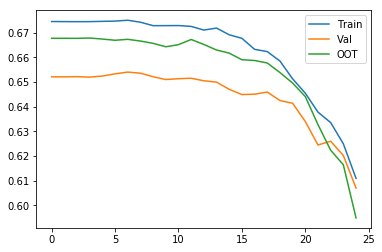

In [35]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [39]:
# At iteration 40 more or less it stays stable
final_features_bucketing = [feats for it, feats in features_it_pval if it==24][0]
# Train the final model with the interesting buckets
lr_final = LogisticRegression(solver='lbfgs', C=0.01)
lr_final.fit(df_tr_preproc[final_features_bucketing], y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
# Predict for all subsets
pred_tr = lr_final.predict_proba(df_tr_preproc[final_features_bucketing])[:, 1]
pred_val = lr_final.predict_proba(df_val_preproc[final_features_bucketing])[:, 1]
pred_oot = lr_final.predict_proba(df_oot_preproc[final_features_bucketing])[:, 1]

get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

(0.6109714472670367, 0.6070470853940936, 0.5949445316056055)

In [41]:
p_values = get_p_vals(lr_final, df_tr_preproc[final_features_bucketing])
show_lr_summary(p_values, final_features_bucketing, lr_final)

,feature,betas,p_val
0,StatedMonthlyIncome_6667|483333,-0.492646,1.618319e-14
1,ScorexChangeAtTimeOfListing_NA,0.324604,4.605055e-23
2,CreditScoreRangeLower_740|880,-0.501609,5.929455e-12


#### AUC based feature selection

In [43]:
# Try to remove all available features.
# Remove the feature that has the lowest impact in AUC
N_iterations = len(glm_cols) - 3
glm_cols_auc = [c for c in glm_cols]

auc_train, auc_val, auc_oot = [], [], []
features_it_auc = []
for it in range(N_iterations):
    print('Working for iteration: {}'.format(str(it)))
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_auc], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_auc])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_auc])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_auc])[:, 1]
    #get base aucs
    auc_train_it, auc_val_it, auc_oot_it = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)
    auc_train.append(auc_train_it)
    auc_val.append(auc_val_it) 
    auc_oot.append(auc_oot_it)
    #set up minimum gap
    min_gap = 500
    for feat_eval in glm_cols_auc:
        #use validation AUC only as evaluation metric
        #keep features in iteration it, but the feature under evaluation
        glm_cols_auc_ev = [c for c in glm_cols_auc if c!=feat_eval]
        lr_it_ev = LogisticRegression(solver='lbfgs', C=0.01)
        lr_it_ev.fit(df_tr_preproc[glm_cols_auc_ev], y_tr)
        #predit @ val data
        pred_val = lr_it_ev.predict_proba(df_val_preproc[glm_cols_auc_ev])[:, 1]
        #get auc @ val
        auc_val_it_ev = get_auc(y_val, pred_val)
        #check gap
        gap_val_auc = auc_val_it - auc_val_it_ev
        #capture the feature that has the lowest AUC impact
        if gap_val_auc < min_gap:
            candidate_drop = feat_eval
            min_gap = gap_val_auc
    #remove from the feature set the selected feature
    glm_cols_auc.remove(candidate_drop)
    #keep features status at iteration
    features_it_auc.append((it, [c for c in glm_cols_auc]))

Working for iteration: 0
Working for iteration: 1
Working for iteration: 2
Working for iteration: 3
Working for iteration: 4
Working for iteration: 5
Working for iteration: 6
Working for iteration: 7
Working for iteration: 8
Working for iteration: 9
Working for iteration: 10
Working for iteration: 11
Working for iteration: 12
Working for iteration: 13
Working for iteration: 14
Working for iteration: 15
Working for iteration: 16
Working for iteration: 17
Working for iteration: 18
Working for iteration: 19
Working for iteration: 20
Working for iteration: 21
Working for iteration: 22
Working for iteration: 23
Working for iteration: 24


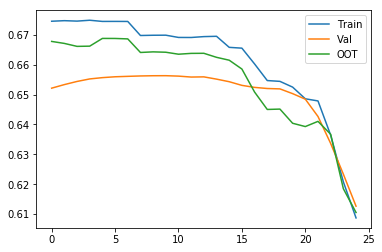

In [44]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [47]:
# get the iteration where it stays stable
final_features_bucketing_auc = [feats for it, feats in features_it_auc if it==24][0]
# Train the final model with the interesting buckets
lr_final_auc = LogisticRegression(solver='lbfgs', C=0.01)
lr_final_auc.fit(df_tr_preproc[final_features_bucketing_auc], y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
# Predict for all subsets
pred_tr = lr_final_auc.predict_proba(df_tr_preproc[final_features_bucketing_auc])[:, 1]
pred_val = lr_final_auc.predict_proba(df_val_preproc[final_features_bucketing_auc])[:, 1]
pred_oot = lr_final_auc.predict_proba(df_oot_preproc[final_features_bucketing_auc])[:, 1]

get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

(0.5987339412818311, 0.5994062602975319, 0.6063544723360159)

#### Gain Table

In [50]:
# Tabla de eficiencia / Gain table
def get_gain_table(pred, df, col_target='bad', n_buckets=10):
    """Generate the gain table given a population, and its predictions
    
    Args:
        pred: np.array / pd.Series containing predictions
        df: Pandas DataFrame containing the population to be assesed
        col_target: Name of the target column
        n_buckets: Number of buckets for the gain table
        
    Returns:
        Pandas DataFrame representing the gain table
    """
    df['pred'] = pred
    df['pred_cut'] = pd.cut(df['pred'], df['pred'].quantile(np.linspace(0, 1, num = n_buckets + 1)), include_lowest=True, duplicates='drop')
    
    #df['pred_cut'] = pd.qcut(df['pred'], n_buckets + 1)

    gain_table = df.groupby('pred_cut').agg({'pred': 'mean',
                                              col_target: ['mean', 'sum'],
                                             'pred_cut': 'size'})

    gain_table.columns = ['N', 'avg_pred', 'BR', 'N_bads']
    gain_table['N_goods'] = gain_table['N'] - gain_table['N_bads']
    gain_table['pct_bad_acum'] = 100. * gain_table['N_bads'].cumsum() / gain_table['N_bads'].sum()
    gain_table['pct_approv_acum'] = 100. * gain_table['N'].cumsum() / gain_table['N'].sum()
    gain_table
    
    return gain_table
# gain table for OOT sample
get_gain_table(pred_oot, df_oot)

,N,avg_pred,BR,N_bads,N_goods,pct_bad_acum,pct_approv_acum
pred_cut,,,,,,,
"(0.065, 0.0833]",0.068906,0.063830,78.0,1222,-1221.931094,22.376854,14.697643
"(0.0833, 0.109]",0.107624,0.127351,413.0,3243,-3242.892376,81.761582,37.653654
"(0.109, 0.135]",0.135473,0.178357,89.0,499,-498.864527,90.899103,66.549843
"(0.135, 0.157]",0.156823,0.227364,113.0,497,-496.843177,100.000000,100.000000


In [51]:
# gain table for training sample
get_gain_table(pred_tr, df_train)

,N,avg_pred,BR,N_bads,N_goods,pct_bad_acum,pct_approv_acum
pred_cut,,,,,,,
"(0.065, 0.0833]",0.068853,0.051892,181.0,3488,-3487.931147,20.533349,14.683780
"(0.0833, 0.109]",0.107757,0.106646,1088.0,10202,-10201.892243,80.591040,37.664290
"(0.109, 0.135]",0.135473,0.155748,252.0,1618,-1617.864527,90.115971,66.555549
"(0.135, 0.157]",0.156823,0.179273,301.0,1679,-1678.843177,100.000000,100.000000


### Random Forest

In [52]:
# Lighther preprocessing
# Handle NAs @ numeric features
# fill with a value lower than its minimum
# We can reuse previopus categorical preprocessing

dtypes = df_train[final_features].dtypes
num_feats = dtypes[dtypes!=object].index.values.tolist()
cat_feats = dtypes[dtypes==object].index.values.tolist()

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [53]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [54]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val, list_df_oot = [df_train_fill[num_feats]], [df_val_fill[num_feats]], [df_oot_fill[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_feats:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf = pd.concat(list_df_val, axis=1)
df_oot_preproc_rf = pd.concat(list_df_oot, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

In [55]:
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=300, 
                            max_depth=4, ## mayor a 8 ya sería peligroso y puede crear overfitting ya que el árbol sería muy grande para un dataset de 20.000 muestras.
                            n_jobs=4)
rf.fit(df_tr_preproc_rf[keep_cols_rf], y_tr)

# Predict for all subsets
pred_tr = rf.predict_proba(df_tr_preproc_rf[keep_cols_rf])[:, 1]
pred_val = rf.predict_proba(df_val_preproc_rf[keep_cols_rf])[:, 1]
pred_oot = rf.predict_proba(df_oot_preproc_rf[keep_cols_rf])[:, 1]

# Get AUC metrics in all subsets
get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

(0.6873895021575693, 0.654263535564948, 0.6702952039571167)

In [56]:
# Show Feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': rf.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

,feature,importance
2,StatedMonthlyIncome,0.271631
5,CreditScoreRangeLower,0.158431
3,InquiriesLast6Months,0.139436
4,ScorexChangeAtTimeOfListing,0.124451
1,MonthlyLoanPayment,0.077699
6,CurrentCreditLines,0.071675
7,"IncomeRange_$25,000-49,999",0.061591
0,TotalTrades,0.042577
10,IncomeRange_Other,0.031196
12,Occupation_Other,0.008774


### XGBoost

In [57]:
from xgboost import XGBClassifier
# Train a XGBoost-Classifier
xgb = XGBClassifier(max_depth=4,
                    learning_rate=0.05, ## velocidad de aprendizaje del modelo
                    n_estimators=300, 
                    min_child_weight=250,
                    n_jobs=4)
xgb.fit(df_tr_preproc_rf[keep_cols_rf], y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=250, missing=None, n_estimators=300,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
# Predict for all subsets
pred_tr = xgb.predict_proba(df_tr_preproc_rf[keep_cols_rf])[:, 1]
pred_val = xgb.predict_proba(df_val_preproc_rf[keep_cols_rf])[:, 1]
pred_oot = xgb.predict_proba(df_oot_preproc_rf[keep_cols_rf])[:, 1]

get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

(0.7096005411385843, 0.6672107023612665, 0.6722245525727069)

In [59]:
# Sow feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': xgb.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

,feature,importance
1,MonthlyLoanPayment,0.269646
2,StatedMonthlyIncome,0.183359
5,CreditScoreRangeLower,0.147149
3,InquiriesLast6Months,0.109399
0,TotalTrades,0.104006
4,ScorexChangeAtTimeOfListing,0.094761
6,CurrentCreditLines,0.075501
12,Occupation_Other,0.007704
7,"IncomeRange_$25,000-49,999",0.005393
8,"IncomeRange_$50,000-74,999",0.003082
